In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [41]:
import os
import pickle
import operator
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
import matplotlib.pyplot as plt

from bprime.tree_utils import load_recrates, load_neutregions
from bprime.models import BGSModel 
from bprime.utils import load_bed_annotation, load_seqlens, RecMap, midpoint, arg_nearest
from bprime.utils import read_bkgd

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


### bgspy B maps

In [44]:
annot = load_bed_annotation(f"../data/annotation/conserved_by_chrom/chr10.bed")
seqlens = load_seqlens("../data/annotation/hg38_seqlens.tsv")
recmap = RecMap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt", seqlens=seqlens, conversion_factor=1e-8)

m = BGSModel(recmap, annot,
             seqlens={'chr10': seqlens['chr10']}, 
             w_grid=np.array([1e-7, 5e-7, 1e-8, 1e-9]),
             t_grid=np.array([0.1, 0.01, 0.001, 0.0001]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'
if False and os.path.exists(pkl_b_file):
    m.load_B(pkl_b_file)
else:
    m.calc_B(step=1_000, ncores=70, nchunks=70)
    m.save_B(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
pre-computing segment contributions...	done.
Genome divided into 70 chunks to be processed on 70 CPUs...


/home/vsb/projects/bprime/notebooks/../bprime/utils.py:438: UserWarning: some positions [133798000] are greater than sequence length (133797422
  overrun = any(overrun)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [04:26<00:00,  3.80s/it]


### `calc_bkgd` maps

In [7]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd_file = os.path.join(bkgd_dir, "calc_bkgd_mu1e-8.pkl")

if not os.path.exists(cached_bkgd_file):
    bkgd_runs = [os.path.join(bkgd_dir, f) for f in os.listdir(bkgd_dir) if f.startswith('calc_bkgd_s')]

    def load_bkgd(run):
        files = os.listdir(run)
        bkgd = dict()
        for file in files:
            chrom = file.replace('.bkgd', '')
            try:
                bkgd[chrom] = read_bkgd(os.path.join(run, file))
            except ValueError:
                continue
                raise ValueError(f"parsing error at {run}/{file}")
        return bkgd

    bkgd = dict()
    for run in bkgd_runs:
        s = os.path.basename(run).replace('calc_bkgd_s', '')
        bkgd[float(s)] = load_bkgd(run)

    with open(cached_bkgd_file, 'wb') as f:
        pickle.dump(bkgd, f)
else:
    with open(cached_bkgd_file, 'rb') as f:
        bkgd = pickle.load(f)

### Simulation Results

In [37]:
DATADIR = '../data/slim_sims/bgsmaptest/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]

In [38]:
len(tree_files)

142

In [10]:
def get_b(file, params, recrate=1e-8, seed=None):
    "Recapitate trees and calc B"
    ts = pyslim.load(file)
    md = ts.metadata['SLiM']['user_metadata']
    region_length = md['region_length'][0]
    N = md['N'][0]
    #recmap = load_recrates('../data/annotation/rec_100kb_chr10.bed', ts.sequence_length)
    rts = pyslim.recapitate(ts, recombination_rate=recrate, sequence_length=ts.sequence_length,
                            ancestral_Ne=N, random_seed=seed)
    length = int(ts.sequence_length)
    neut_positions = np.linspace(0, length, length // 1000).astype(int)
    params = {k: md[k][0] for k in params}
    return tuple(params.items()), neut_positions, rts.diversity(mode='branch', windows=neut_positions) / (4*N)



In [11]:
get_b(tree_files[0], ('s', 'mu'))

((('s', 0.0002), ('mu', 1e-08)),
 array([        0,      1000,      2000, ..., 129997999, 129998999,
        130000000]),
 array([1.24843136, 1.24726261, 1.24726261, ..., 0.98173282, 0.98173282,
        0.98173282]))

In [47]:
#cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'
cached_bgsmap_file = '../data/bmaps/bgsmaptest_sims.pkl'


if force or not os.path.exists(cached_bkgd_file):
    sims = defaultdict(list)

    for file in tqdm.tqdm(tree_files):
        params, pos, b = get_b(file, ('s', 'mu'))
        sims[params].append((pos, b))

    for key, res in sims.items():
        pos = list(map(operator.itemgetter(0), res))
        b = list(map(operator.itemgetter(1), res))
        sims[key] = np.stack(pos)[0, :], np.stack(b).T
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:41<00:00,  3.43it/s]


Text(0, 0.5, 'B')

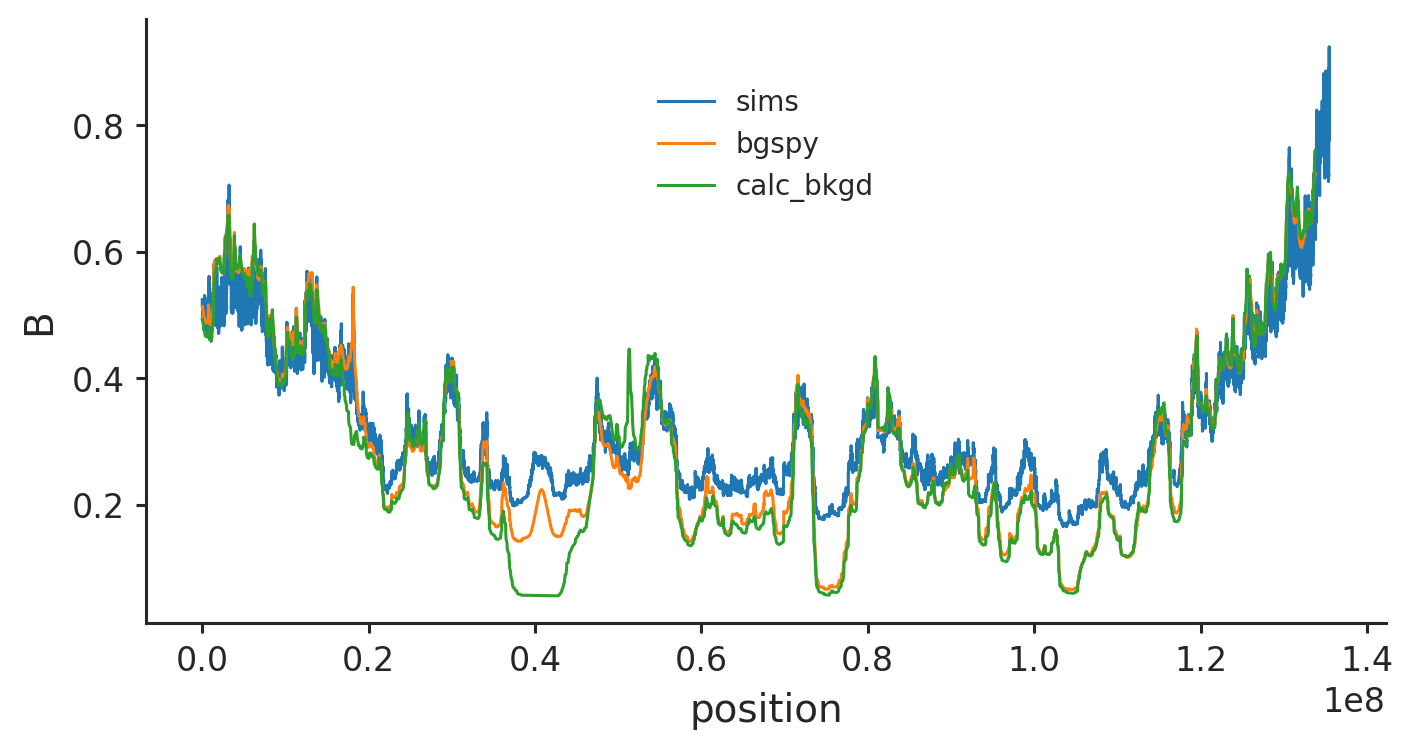

In [49]:
s, mu = 0.02, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='upper center')
ax.set_xlabel('position')
ax.set_ylabel('B')

In [15]:
m.segments.ranges.shape

(13402, 2)

In [16]:
i = np.zeros(seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]

In [17]:
wins = np.linspace(0, seqlens['chr10'], seqlens['chr10'] // 100_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

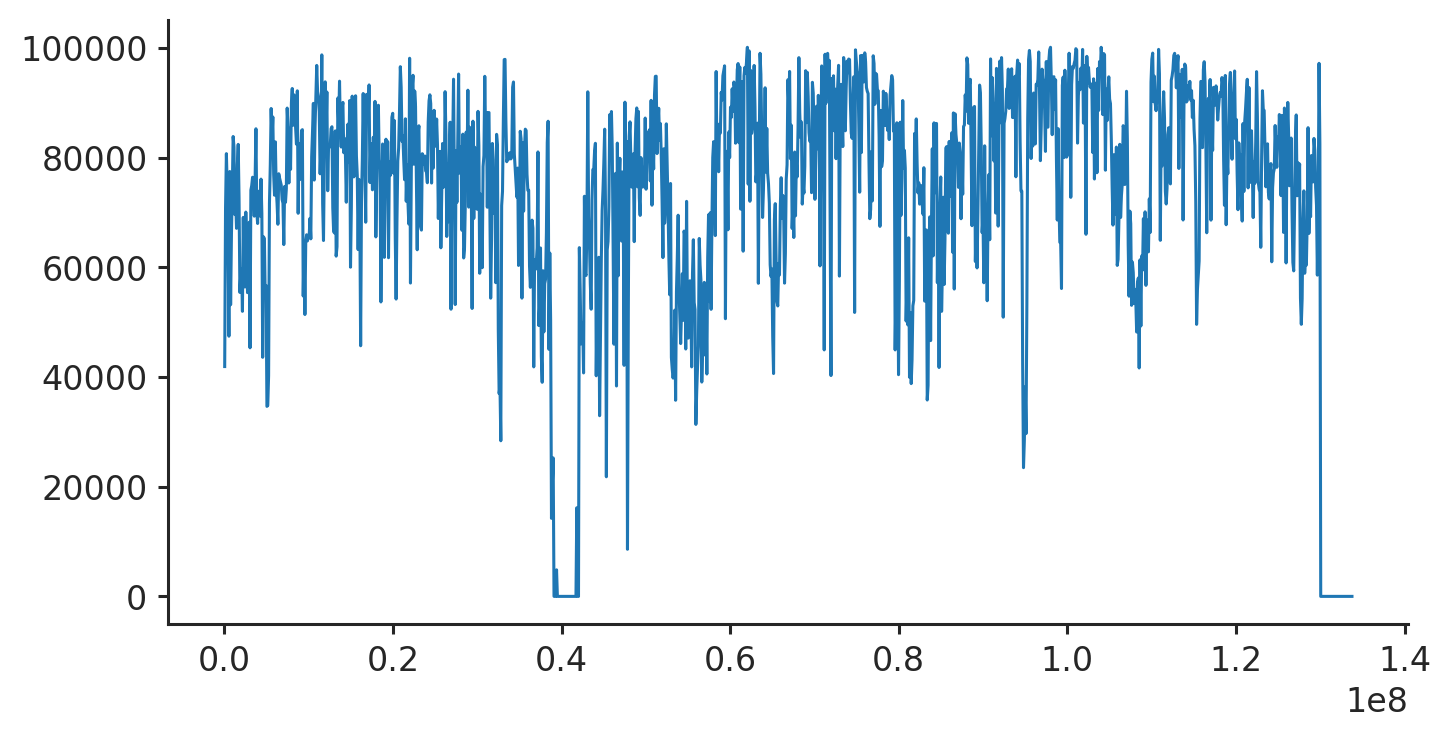

In [18]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic)

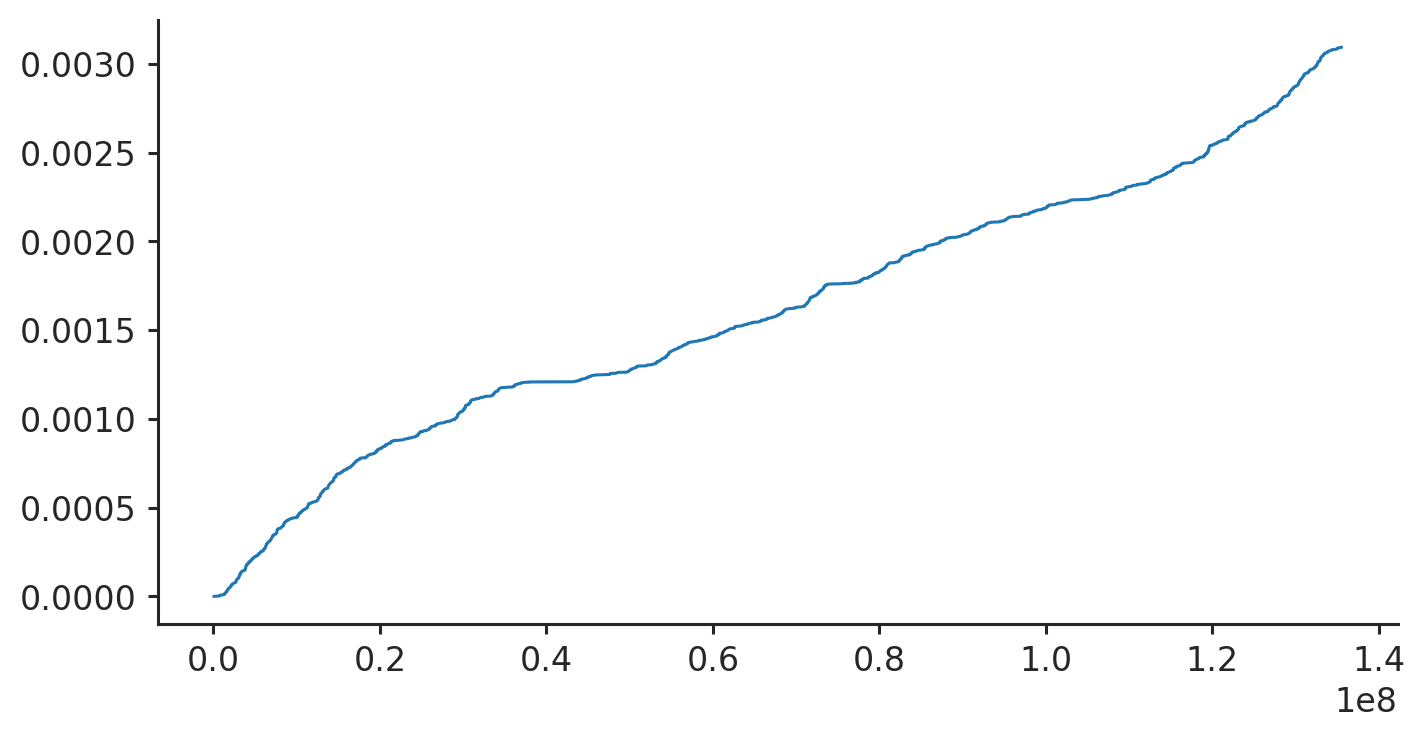

In [25]:
rec = m.recmap.rates['chr10']
plt.plot(rec.end[1:], np.cumsum(rec.rate[1:]))
#plt.scatter(rec.end, rec.rate, s=1)

In [54]:
rec.end

array([        0,     72765,     94172, ..., 135499163, 135499327,
       135503693])

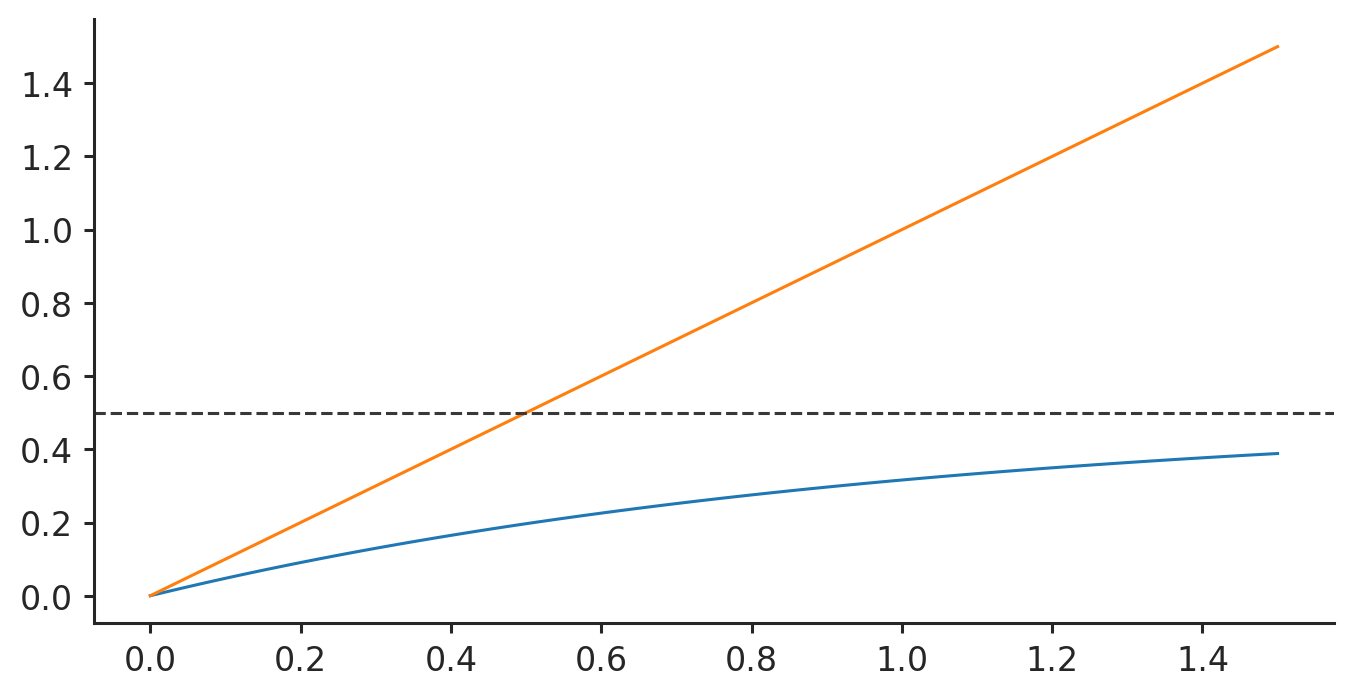

In [67]:
d = np.linspace(1e-8, 1.5, 100)
fig, ax = plt.subplots()
ax.plot(d, -0.5*np.expm1(-d))
ax.plot(d, d)
ax.axhline(0.5, linestyle='dashed', c='0.22')
#ax.loglog()

In [280]:
results.keys()

dict_keys([(('s', 0.0002), ('mu', 1e-08)), (('s', 0.02), ('mu', 1e-08)), (('s', 2e-05), ('mu', 1e-08)), (('s', 0.002), ('mu', 1e-08))])

Text(0, 0.5, 'B')

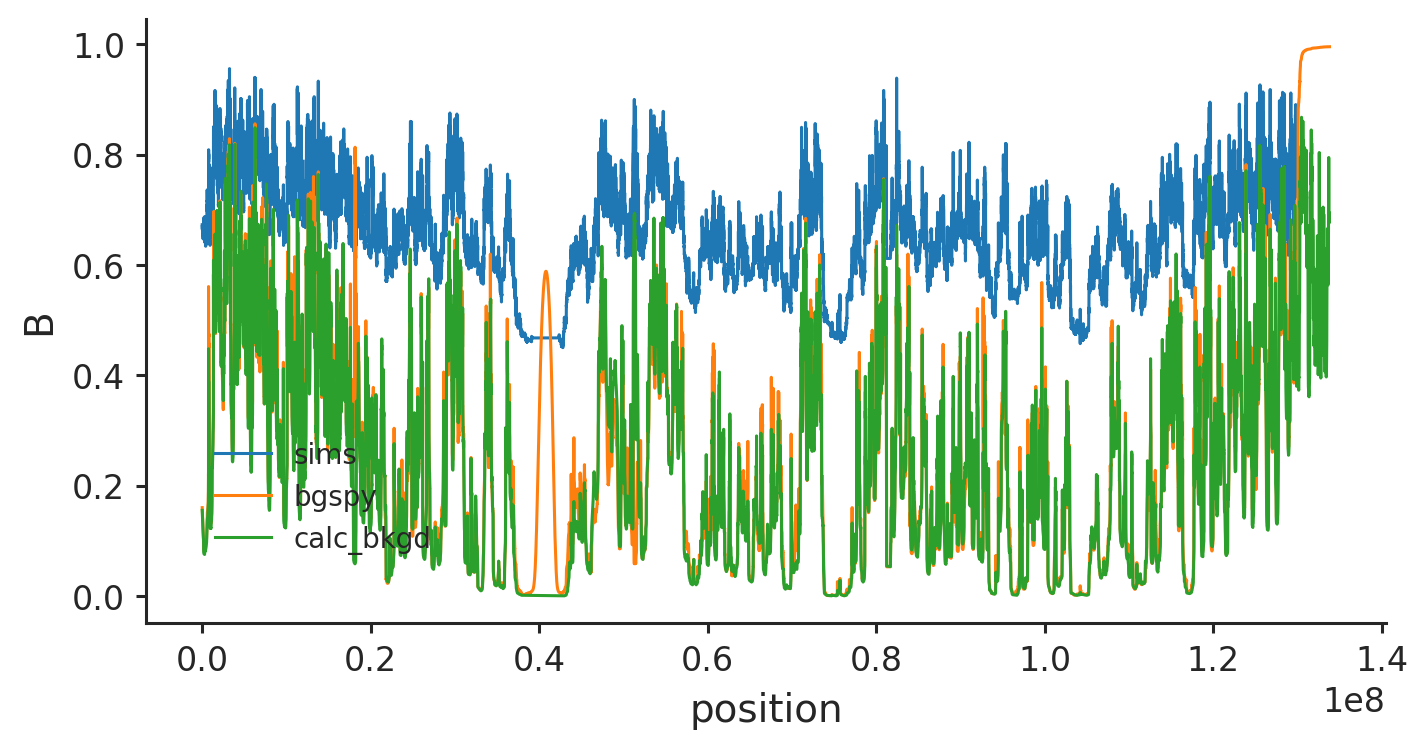

In [26]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')

In [41]:
idx = m.segments.index['chr10']
mp = m.segments.ranges[idx, ...].mean(axis=1)
p = np.argmin(np.abs(mp - 0.4e8))
m.segments.ranges[idx, ...][p, ...]

array([39430021, 39434862], dtype=uint32)

In [42]:
m.recmap.lookup('chr10', 39430021)

3.4766399999999997e-09

In [55]:
s, e = 0.375e8, 0.43e8
cent_mappos = m.recmap.lookup('chr10', np.array([s, e]), cummulative=True)
cent_mappos

array([0.64947207, 0.66250452])

In [92]:
m.recmap.lookup('chr10', 39154220, cummulative=True), m.recmap.lookup('chr10', 39154220, cummulative=True)

(array(0.65084659), array(0.65084659))

In [93]:
0.037982 * 1e-8

3.7982000000000004e-10

In [86]:
int(s), int(e)

(37500000, 43000000)

In [56]:
np.diff(cent_mappos)

array([0.01303245])

In [59]:
rec.rate[np.argmin(np.abs(rec.end - s))], rec.rate[np.argmin(np.abs(rec.end - e))]

(7.6135e-10, 3.2138099999999997e-09)

In [61]:
np.mean((7.6135e-10, 3.2138099999999997e-09))*(e-s)

0.010931689999999999

In [68]:
parts = m._segment_parts
a, b, c, d = parts
[x.shape for x in parts]

[(4, 145277), (4, 1), (4, 145277), (4, 145277)]

In [70]:
a, b, c, d = parts[0][:, idx], parts[1], parts[2][:, idx], parts[3][:, idx]

In [82]:
rf = 0.01
x = a/(b*rf**2 + c*rf + d)
np.exp(np.einsum('ts,w,sf->wtf', x, m.w, m.F))[2, 1, 0]

1.9987752688457133e-11